1. Global methane levels from 2002
Methane (CH4) is a naturally occurring Greenhouse Gas (GHG), but one whose abundance has been increased substantially above its pre-industrial value by human activities, primarily because of agricultural emissions (e.g., rice production, ruminants) and fossil fuel production and use. A clear annual cycle is largely due to seasonal wetland emissions.

Atmospheric methane abundance is indirectly observed by various satellite instruments. These instruments measure spectrally resolved near-infrared and infrared radiation reflected or emitted by the Earth and its atmosphere. In the measured signal, molecular absorption signatures from methane and constituent gasses can be identified. It is through analysis of those absorption lines in these radiance observations that the averaged methane abundance in the sampled atmospheric column can be determined.

For this problem set, methane levels have been determined by applying several algorithms to different satellite instruments. Download the netCDF4 file (200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc) here, which contains monthly-averaged methane levels (xch4) in the unit of ppb at each 5° (lon) x 5° (lat) grid over the globe from 2003-01 to 2020-06.


1.1 [5 points] Compute methane climatology for each month, and plot your results in 12 panels.

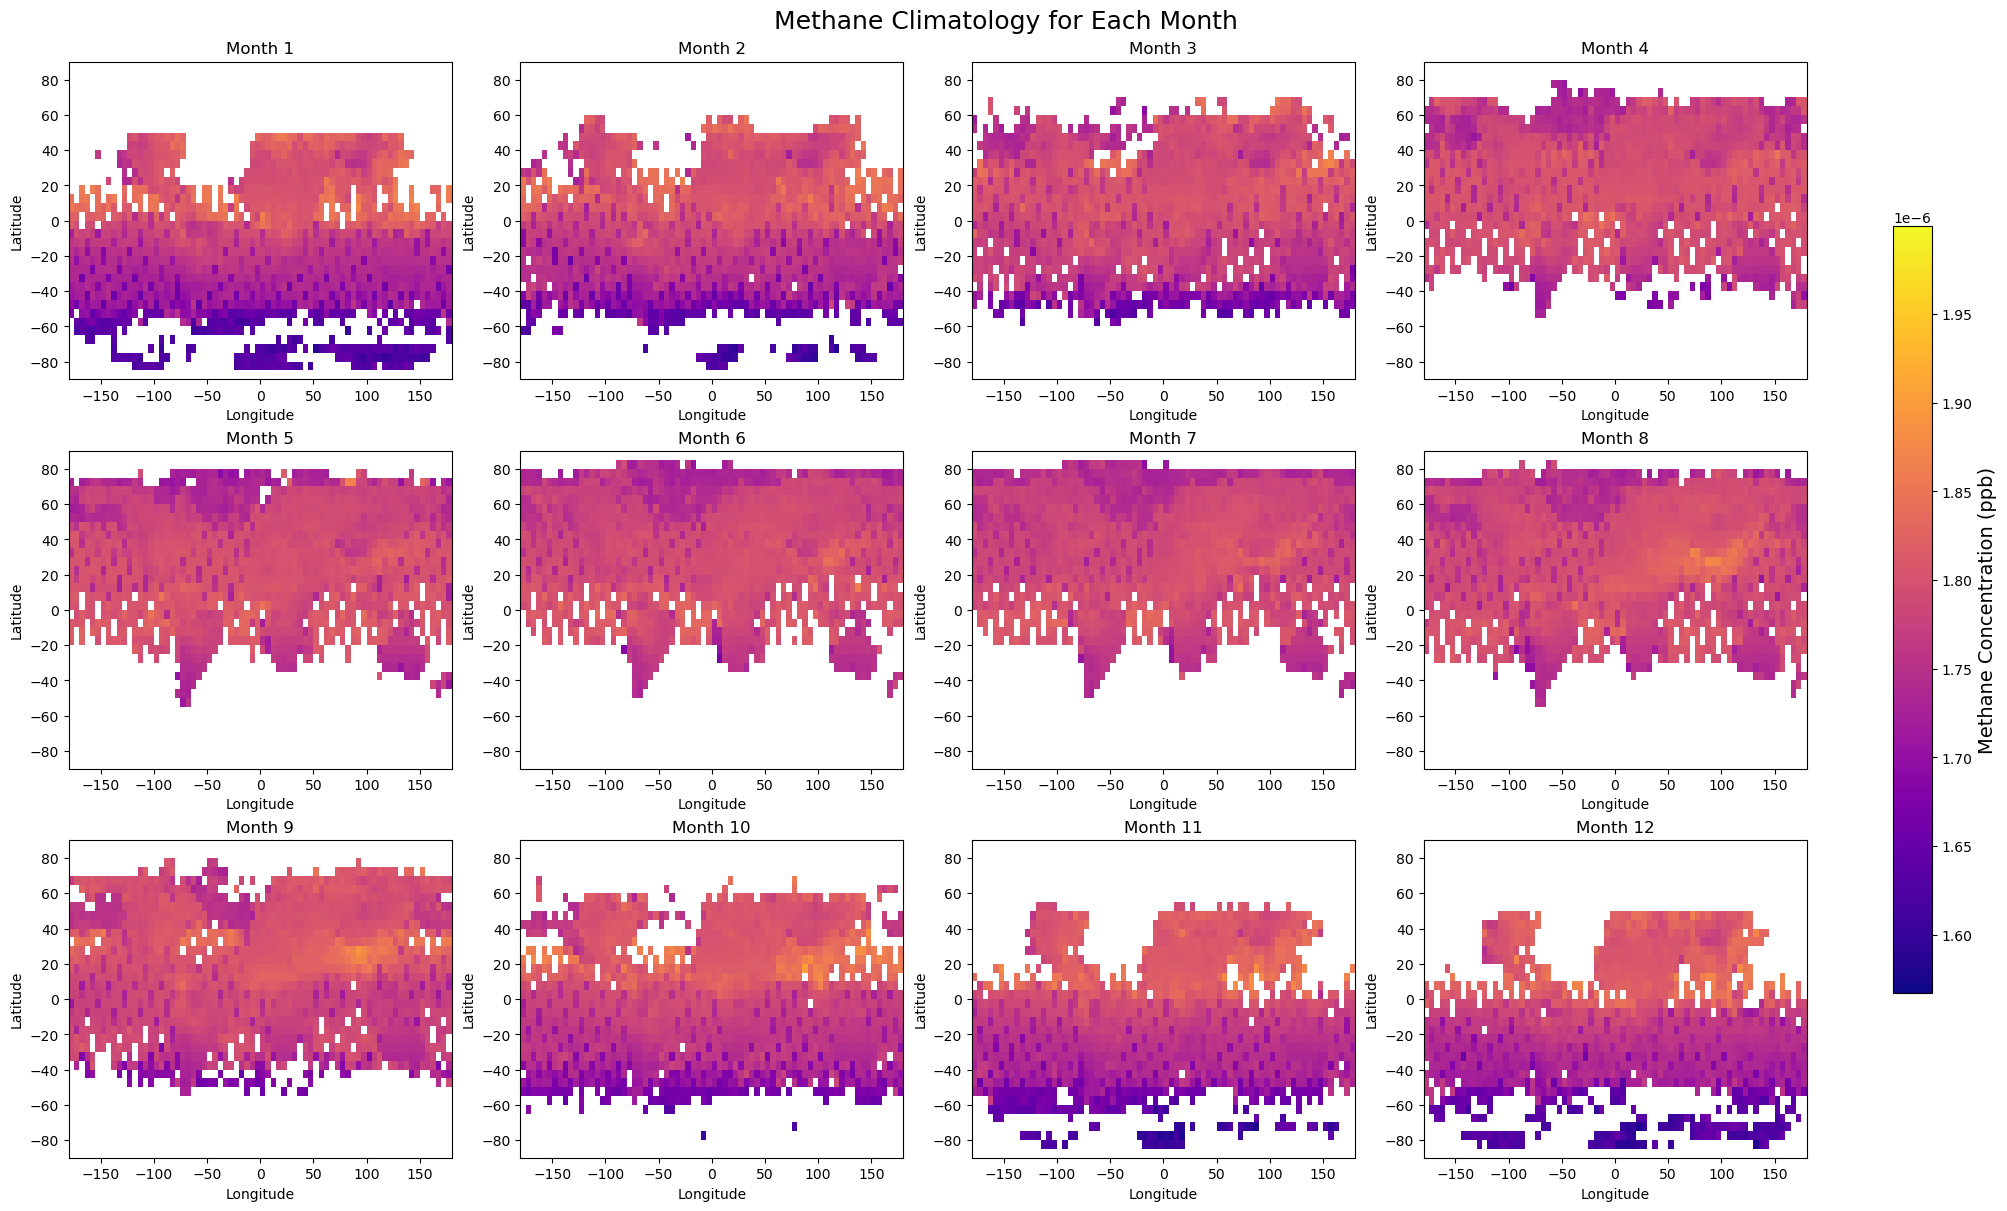

In [9]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# 读取netCDF文件
file_path = "200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc"
data = xr.open_dataset(file_path)

# 提取甲烷浓度和相关数据
xch4 = data['xch4']
time = xr.decode_cf(data).time
xch4['time'] = time

# 按月份分组并计算气候学平均值
monthly_climatology = xch4.groupby("time.month").mean(dim="time")

# 创建一个12子图的布局
fig, axes = plt.subplots(3, 4, figsize=(20, 12), constrained_layout=True)
fig.suptitle('Methane Climatology for Each Month', fontsize=18)

# 绘制每个月的气候学平均值
im = None  # 用于保存颜色条的图例句柄
for month in range(1, 13):
    ax = axes[(month-1) // 4, (month-1) % 4]
    month_data = monthly_climatology.sel(month=month)
    im = ax.pcolormesh(
        data['lon'], data['lat'], month_data,
        shading='auto', cmap='plasma', vmin=np.nanmin(xch4), vmax=np.nanmax(xch4)
    )
    ax.set_title(f'Month {month}', fontsize=12)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# 添加一个全局竖直颜色条
cbar = fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.7, pad=0.05)
cbar.set_label('Methane Concentration (ppb)', fontsize=14)

plt.show()


1.2 [5 points] Plot globally-averaged methane from 2003-01 to 2020-06 as a time series. Describe your results. Check your plot with this one.

从2023年到20220年，每年的全球甲烷平均浓度随月份呈季节性变化，每年全球甲烷平均浓度呈逐年上升趋势。

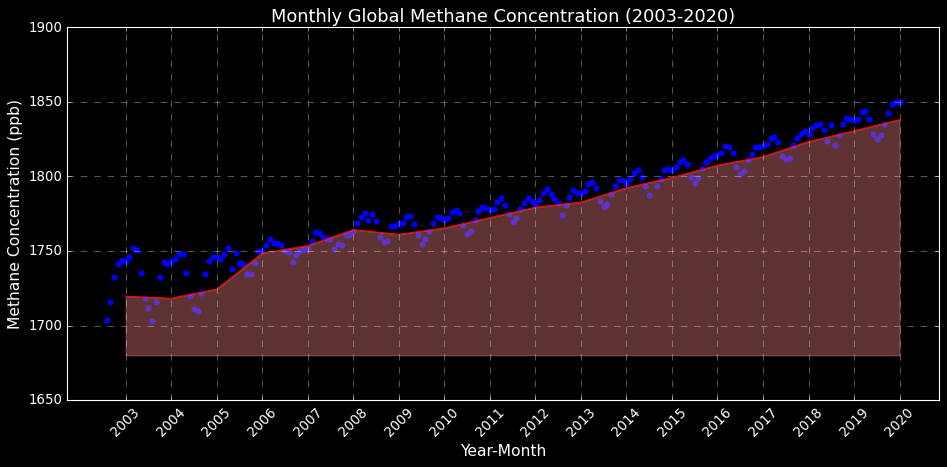

In [95]:
# 提取 'year' 和 'month' 维度
xch4['year'] = xch4['time'].dt.year
xch4['month'] = xch4['time'].dt.month

# 创建一个复合维度 ('year', 'month')，用来按年和月分组
xch4['year_month'] = 100 * xch4['year'] + xch4['month']

#对年求平均 计算趋势
yearlyAveraged = xch4.groupby('year').mean(dim='time')
yearlyAveraged = yearlyAveraged.mean(dim=["lat", "lon"]) * 1e9

# 按照 'year_month' 分组，并计算每个组的平均值
monthlyAveraged = xch4.groupby('year_month').mean()
# 对每个月的空间点（经纬度）求平均值，并转换为 ppb
global_monthly_mean = monthlyAveraged.mean(dim=["lat", "lon"]) * 1e9

x_intervals = range(len(xch4["time"]))
# 绘制每个月的全球甲烷浓度
plt.figure(figsize=(12, 6))
plt.style.use("dark_background")  # 黑色背景
plt.scatter(x_intervals, global_monthly_mean, marker='o', color='blue',s = 20)
years = [str(year) for year in range(2003, 2021)]  # 创建年份列表
x_tick_positions = range(5, len(xch4["time"]), 12) 
plt.plot(x_tick_positions, yearlyAveraged,  color='red')
plt.xticks(x_tick_positions, years, rotation=45)
# 添加图表标题和轴标签
plt.title("Monthly Global Methane Concentration (2003-2020)", fontsize=16)
plt.xlabel("Year-Month", fontsize=14)
plt.ylabel("Methane Concentration (ppb)", fontsize=14)
# 添加网格
plt.grid(True, linestyle='--', alpha=0.6)
# 显示图表
plt.fill_between(
    x_tick_positions,
    yearlyAveraged, 
    1680,  # 填充到下界1600
    color="lightcoral", alpha=0.4, label="Average"
)

plt.tight_layout()
plt.show()

1.3 [5 points] Plot deseasonalized methane levels at point [15°S, 150°W] from 2003-01 to 2020-06 as a time series. Describe your results.

数据中存在一些缺失值，2006年之前的甲烷浓度变化大，2010年之后的甲烷浓度变化稳定

210
<xarray.DataArray 'xch4' (time: 12)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
      dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 2008-01-16T12:00:00 ... 2008-12-16T12:0...
    lat         float64 -12.5
    lon         float64 -147.5
    year        (time) int64 2008 2008 2008 2008 2008 ... 2008 2008 2008 2008
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
    year_month  (time) int64 200801 200802 200803 ... 200810 200811 200812


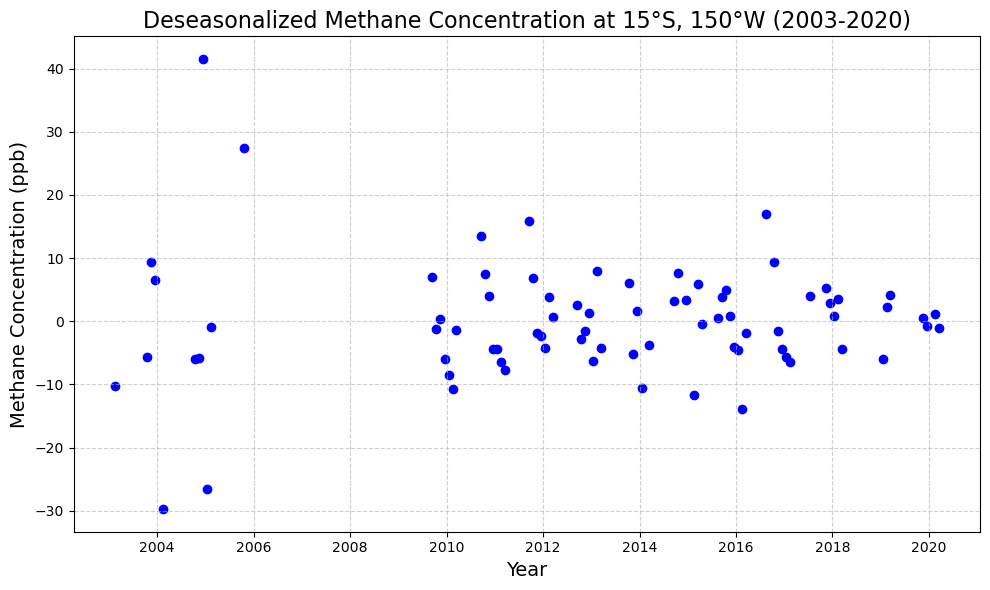

In [27]:
subset = xch4.sel(lat=-15, lon=-150, method='nearest')
MeanYear = subset.groupby("time.year").mean(dim="time")
# 创建一个去季节性数据的数组
temp = subset.copy()
# 创建一个空的列表来存储每年的去季节性数据
deseasonalized_years = []

# 对每个月的数据减去对应年份的年平均值
for year in MeanYear['year'].values:
    # 获取当前年份的年平均值
    year_mean = MeanYear.sel(year=year)
    
    # 获取该年所有月份的数据
    deseasonalized_year = subset.sel(time=subset['time'].dt.year == year) - year_mean
    # 将去季节性数据添加到列表中
    deseasonalized_years.append(deseasonalized_year)

# 将所有年度的去季节性数据拼接成一个新的 xarray.DataArray
deseasonalized = xr.concat(deseasonalized_years, dim="time")
# 绘制去季节性后的甲烷浓度时间序列
plt.figure(figsize=(10, 6))
plt.scatter(deseasonalized['time'], deseasonalized*1e9, marker='o', color='blue')

# 添加标题和标签
plt.title("Deseasonalized Methane Concentration at 15°S, 150°W (2003-2020)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Methane Concentration (ppb)", fontsize=14)

# 添加网格
plt.grid(True, linestyle='--', alpha=0.6)
print(deseasonalized.sel(time=deseasonalized['time'].dt.year == 2008))
# 显示图表
plt.tight_layout()
plt.show()

2. Niño 3.4 index
The Niño 3.4 anomalies may be thought of as representing the average equatorial sea surface temperatures (SSTs) across the Pacific from about the dateline to the South American coast (5N-5S, 170W-120W). The Niño 3.4 index typically uses a 3-month running mean, and El Niño or La Niña events are defined when the Niño 3.4 SSTs exceed +/- 0.5°C for a period of 5 months or more. Check Equatorial Pacific Sea Surface Temperatures for more about the Niño 3.4 index.

In this problem set, you will use the sea surface temperature (SST) data from NOAA. Download the netCDF4 file (NOAA_NCDC_ERSST_v3b_SST.nc) here.



1.1 [10 points] Compute monthly climatology for SST from Niño 3.4 region, and subtract climatology from SST time series to obtain anomalies.


In [84]:
import xarray as xr
import matplotlib.pyplot as plt

# 打开 NOAA SST 数据
sst = xr.open_dataset('NOAA_NCDC_ERSST_v3b_SST.nc')
# 提取 Niña 3.4 区域 (5°N-5°S，170°W-120°W)
nino34_region = sst.sel(lat=slice(-5, 5), lon=slice(-170+180, -120+180))

# 计算每个月的 SST 平均值
sst_climatology = nino34_region.groupby('time.month').mean(dim='time')
# 计算 SST 异常（SST Anomaly）
sst_anomaly = nino34_region.groupby('time.month') - sst_climatology
print(sst_anomaly)
sst_anomaly = sst_anomaly.mean(dim=["lat", "lon"]) 


<xarray.Dataset>
Dimensions:  (lat: 5, lon: 26, time: 684)
Coordinates:
  * lat      (lat) float32 -4.0 -2.0 0.0 2.0 4.0
  * lon      (lon) float32 10.0 12.0 14.0 16.0 18.0 ... 52.0 54.0 56.0 58.0 60.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 -0.6067 -0.5059 nan ... 0.3881 0.3777


In [ ]:
1.2 [10 points] Visualize the computed Niño 3.4. Your plot should look similar to this one

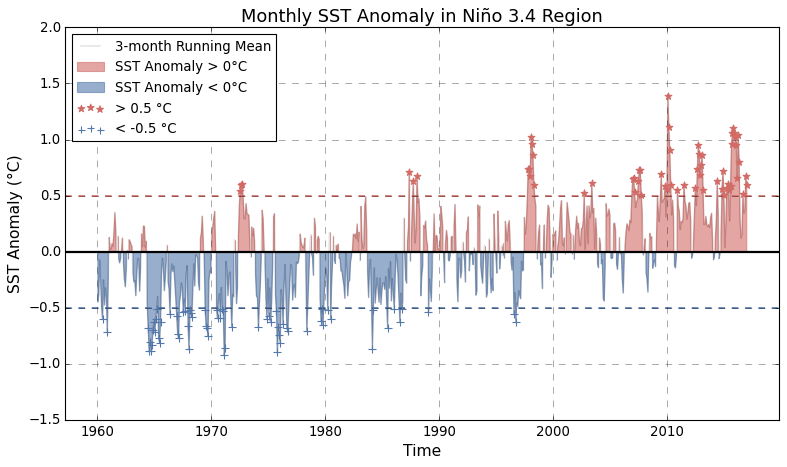

In [86]:
import matplotlib.pyplot as plt
import numpy as np

sst_anomaly = sst_anomaly
# 解析数据
s = sst_anomaly.to_array()
s = s.values
s = s.reshape(-1)
time = sst_anomaly["time"].values
time = time.reshape(-1)

positive_anomaly_indices = s > 0.5
negative_anomaly_indices = s < -0.5
# 黑色背景
plt.style.use('classic')  
# 创建画布，设置背景为白色，使用指定的的颜色
plt.figure(figsize=(10, 6), facecolor='white')

# 绘制 SST 异常折线
plt.plot(time, s, linestyle='-', linewidth=1.5, color='black', alpha=0.1,label='3-month Running Mean', zorder=3)

# 填充曲线下方的区域
plt.fill_between(time, s, color=(210/255, 107/255, 102/255), where=(s > 0), alpha=0.6, label='SST Anomaly > 0°C')  
plt.fill_between(time, s, color=(83/255, 120/255, 172/255), where=(s < 0), alpha=0.6, label='SST Anomaly < 0°C')  

# 标记 >0.5 的点
plt.scatter(time[positive_anomaly_indices], s[positive_anomaly_indices], 
            color=(210/255, 107/255, 102/255), label='> 0.5 °C', zorder=5, marker='*', s=40)  

# 标记 < -0.5 的点
plt.scatter(time[negative_anomaly_indices], s[negative_anomaly_indices], 
            color=(83/255, 120/255, 172/255), label='< -0.5 °C', zorder=5, marker='+', s=40)  

# 添加阈值线
plt.axhline(y=0.5, color=(210/255, 107/255, 102/255), linestyle='--', linewidth=1.5)  
plt.axhline(y=-0.5, color=(83/255, 120/255, 172/255), linestyle='--', linewidth=1.5) 
plt.axhline(y=0, color='black', linewidth=2)  

# 添加标题和标签
plt.title('Monthly SST Anomaly in Niño 3.4 Region', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('SST Anomaly (°C)', fontsize=14)

# 添加网格
plt.grid(True, linestyle='--', alpha=0.6)

# 设置 X 轴刻度
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().set_facecolor('white')
# 添加图例
plt.legend(loc='upper left', fontsize=12)
# 调整布局
plt.tight_layout()

# 显示图表
plt.show()


3. Explore a netCDF dataset
Browse the NASA’s Goddard Earth Sciences Data and Information Services Center (GES DISC) website. Search and download a dataset you are interested in. You are also welcome to use data from your group in this problem set. But the dataset should be in netCDF format, and have temporal information.



3.1 [5 points] Plot a time series of a certain variable with monthly seasonal cycle removed.



3.2 [10 points] Make at least 5 different plots using the dataset.

In [29]:
import xarray as xr
import os

# 定义存放 .nc 文件的文件夹路径
data_folder = "C:/Users/16869/P3DATA"  # 替换为你的文件夹路径

# 搜索文件夹中的所有 .nc 文件
file_list = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".nc4")]

# 使用 xarray 打开多个文件并合并
# 按照时间维度合并
combined_dataset = xr.open_mfdataset(file_list, combine="by_coords")

# 打印合并后的 Dataset 信息
print(combined_dataset)


<xarray.Dataset>
Dimensions:   (lat: 361, lon: 576, time: 86)
Coordinates:
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time      (time) datetime64[ns] 2015-01-16T12:00:00 ... 2022-02-15
Data variables:
    XCO2      (time, lat, lon) float64 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    XCO2PREC  (time, lat, lon) float64 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
Attributes: (12/25)
    RangeBeginningDate:             2017-08-01
    RangeBeginningTime:             00:00:00.000000
    RangeEndingDate:                2017-08-01
    RangeEndingTime:                23:59:99.999999
    SpatialCoverage:                global
    SouthBoundingCoordinate:        -90.0
    ...                             ...
    ProductionDateTime:             2022-03-15T12:04:33Z
    History:                        Original file generated: Tue Mar 15 12:04...
    ShortName:     

<xarray.DataArray 'XCO2' (lat: 361, lon: 576)>
dask.array<getitem, shape=(361, 576), dtype=float64, chunksize=(361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
    month    int64 11
Attributes:
    units:         mol CO2/mol dry
    long_name:     Assimilated dry-air column average CO2 daily mean
    cell_methods:  time: mean


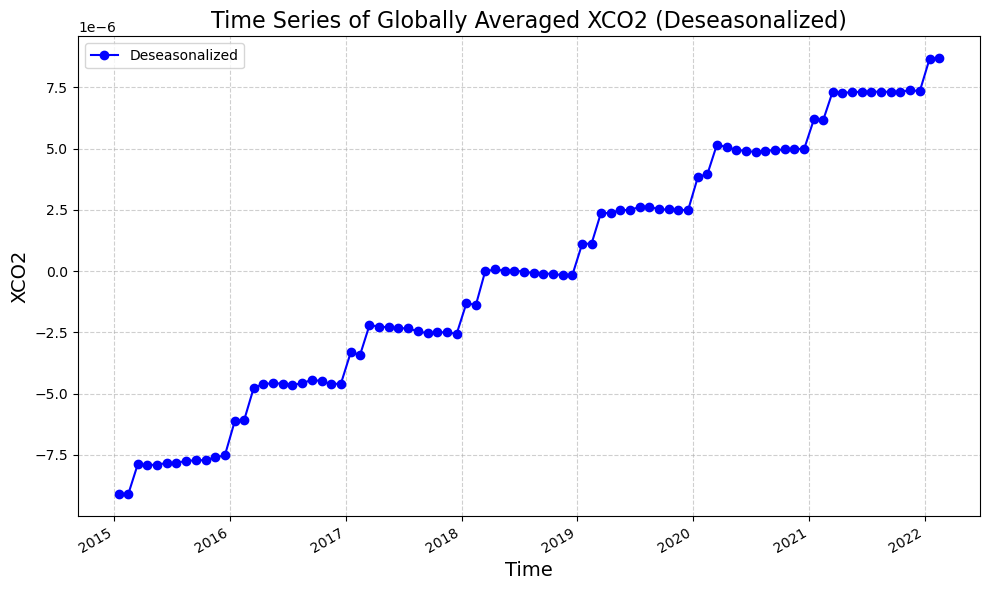

In [75]:
import xarray as xr
import matplotlib.pyplot as plt

# 提取XCO2变量
data = combined_dataset["XCO2"]

# 计算没每月平均值
monthly_mean = data.groupby("time.month").mean(dim="time")
print(monthly_mean.sel(month=11))
# 减去月季循环
deseasonalized = data.groupby("time.month") - monthly_mean

# 对 lat 和 lon 求平均
global_mean = deseasonalized.mean(dim=["lat", "lon"])

# 绘制时间序列
plt.figure(figsize=(10, 6))
global_mean.plot(color="blue", marker="o", linestyle="-", label="Deseasonalized")
plt.title(f"Time Series of Globally Averaged XCO2 (Deseasonalized)", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("XCO2", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

1.绘制11月的月平均热图

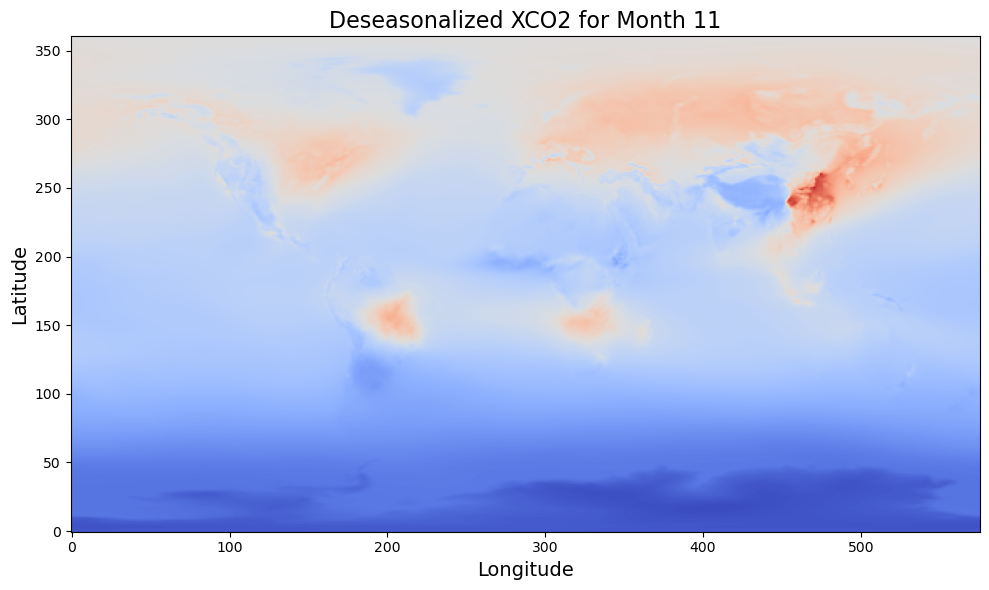

In [77]:
#选择11月数据
deseasonalized_data = monthly_mean.sel(month=11)
#绘制热图
plt.figure(figsize=(10, 6))
cax = plt.imshow(deseasonalized_data.values, cmap="coolwarm", origin="lower", aspect="auto")
plt.title(f"Deseasonalized XCO2 for Month 11", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.tight_layout()
plt.show()

2.查看特定时间点的XCO2全球分布图

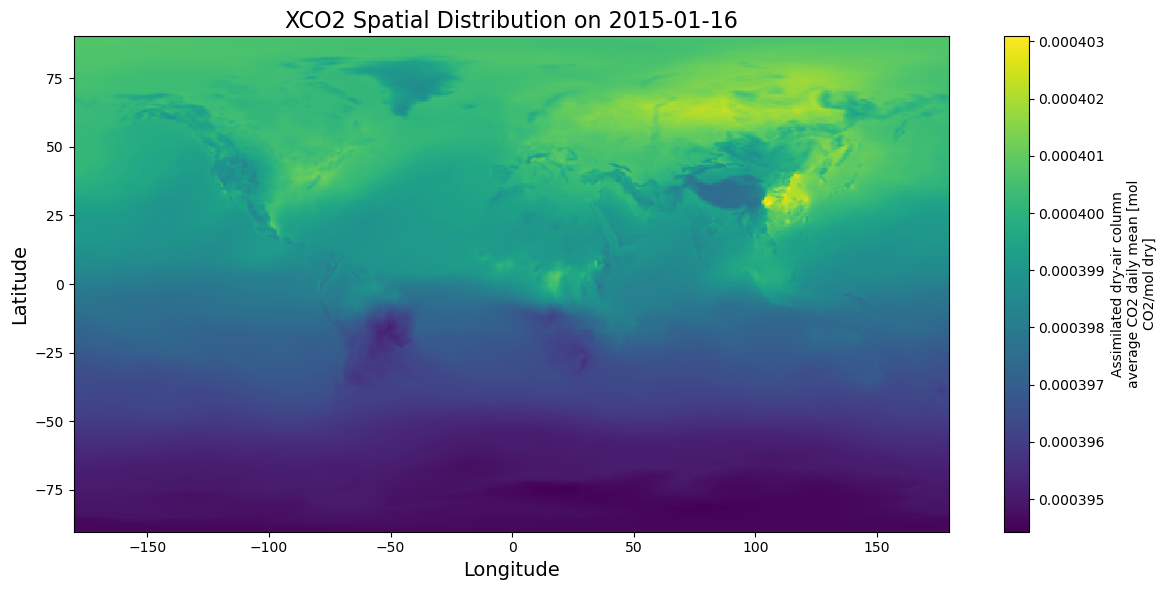

In [74]:
# 选择特定时间点的数据
time_point = "2015-01-16"  # 替换为其他时间点查看
xco2_snapshot = combined_dataset["XCO2"].sel(time=time_point)

plt.figure(figsize=(12, 6))
xco2_snapshot.plot(cmap="viridis")
plt.title(f"XCO2 Spatial Distribution on {time_point}", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
#plt.colorbar(label="XCO2 (ppm)")
plt.tight_layout()
plt.show()

3.查看全球平均XCO2分布随纬度的变化分布曲线

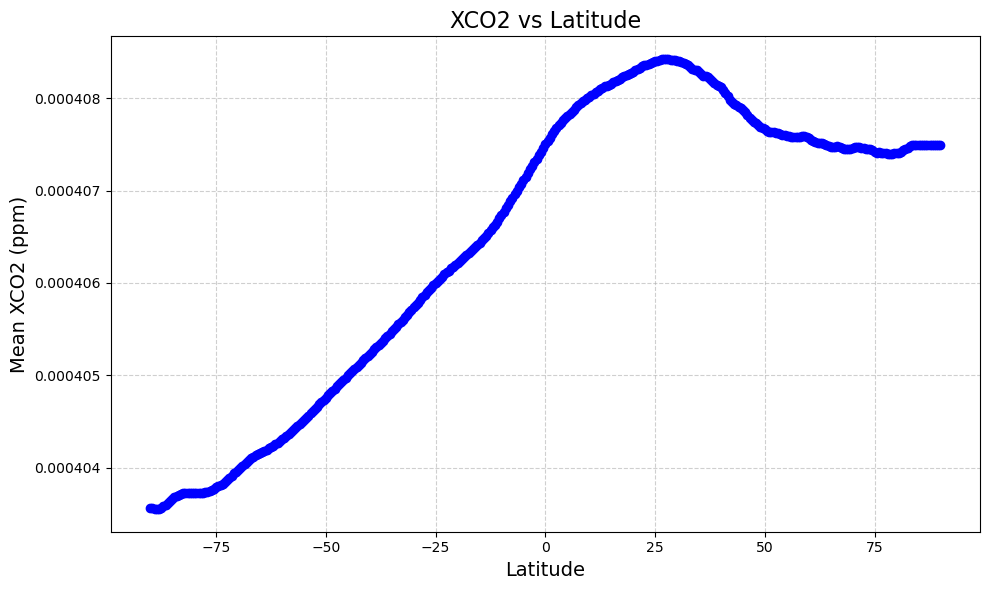

In [38]:
# 按纬度计算平均值
xco2_lat_mean = combined_dataset["XCO2"].mean(dim=["time", "lon"])

plt.figure(figsize=(10, 6))
xco2_lat_mean.plot(color="blue", marker="o", linestyle="-")
plt.title("XCO2 vs Latitude", fontsize=16)
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Mean XCO2 (ppm)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


4.查看全球XCO2平均浓度随经度的变化分布曲线

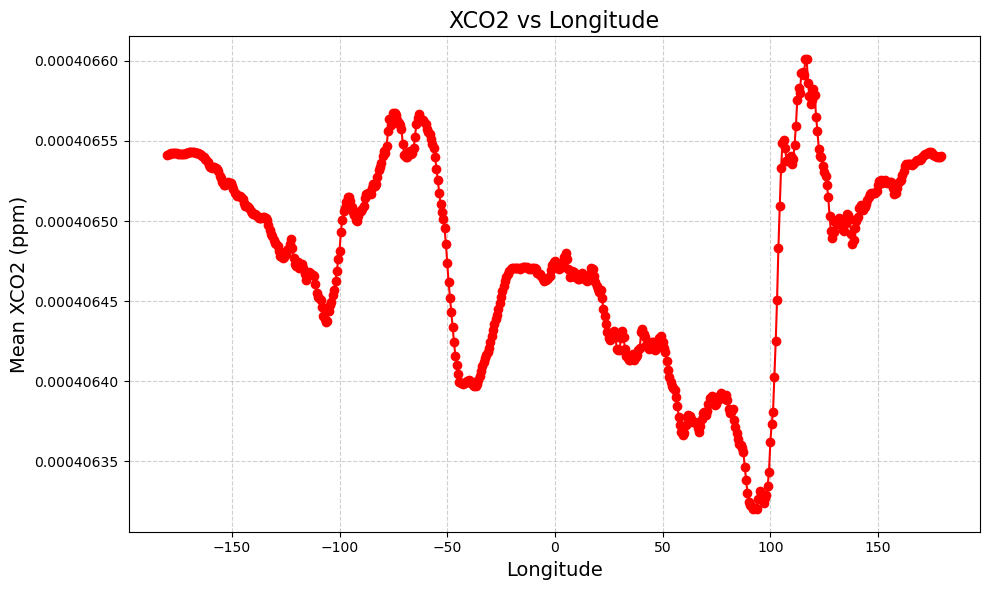

In [39]:
# 按经度计算平均值
xco2_lat_mean = combined_dataset["XCO2"].mean(dim=["time", "lat"])

plt.figure(figsize=(10, 6))
xco2_lat_mean.plot(color="red", marker="o", linestyle="-")
plt.title("XCO2 vs Longitude", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Mean XCO2 (ppm)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

5.查看XCO2在赤道上的分布随时间变化曲线

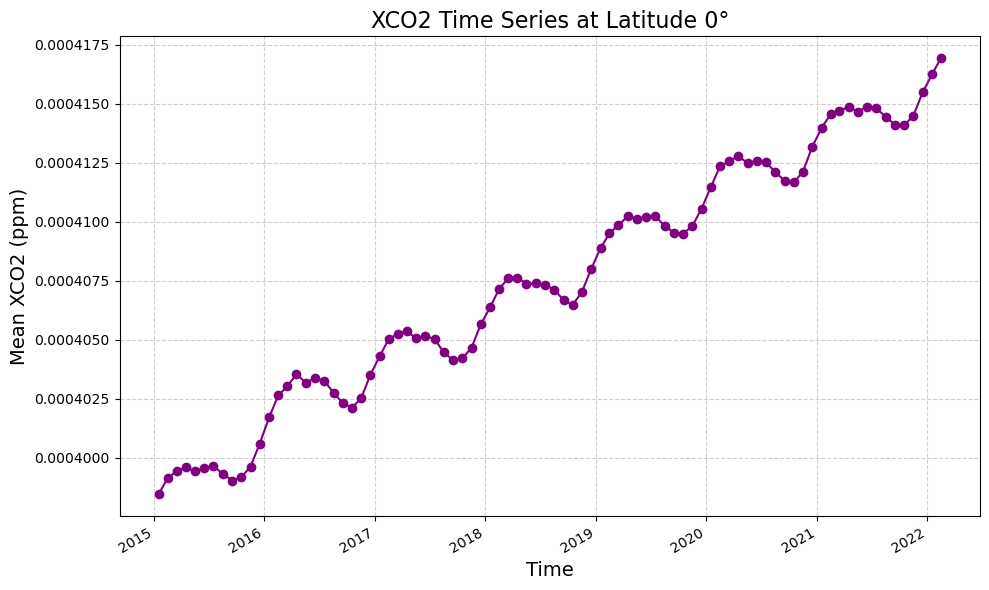

In [48]:
# 选择特定纬度的数据
latitude = 0  # 赤道
xco2_at_lat = combined_dataset["XCO2"].sel(lat=latitude, method="nearest")

plt.figure(figsize=(10, 6))
xco2_at_lat.mean(dim="lon").plot(color="purple", marker="o", linestyle="-")
plt.title(f"XCO2 Time Series at Latitude {latitude}°", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Mean XCO2 (ppm)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
